In [17]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"

from jax import numpy as jnp
import jax
from jax.scipy.interpolate import RegularGridInterpolator

import temgymbasic.jax_components as comp
from temgymbasic.jax_run import run_to_end, run_to_component
from temgymbasic.jax_ray import Ray, propagate
from temgymbasic.jax_utils import get_pytree_idx_from_model, get_pixel_coords
import matplotlib.pyplot as plt

import tqdm.auto as tqdm
%matplotlib widget
import numpy as np

# jax.config.update("jax_enable_x64", True)

SYMPY Mathematics just to understand how to model the descanner with descan error, and how the variables propagate to the end. Feel free to ignore. 

In [18]:
import sympy as sp
x_out, y_out, theta_x_out, theta_y_out = sp.symbols('x_out y_out theta_x_out theta_y_out')
x_in, y_in, theta_x_in, theta_y_in = sp.symbols('x_in y_in theta_x_in theta_y_in')

# Lit pixels from Point Source
# Make a 5x5 matrix for use in sympy with Axx, Axy, Ayx, Ayy, Bxx, Bxy, Byx, Byy... etc values in each quadrant
A_xx, A_xy, A_yx, A_yy = sp.symbols('A_xx A_xy A_yx A_yy', real=True)
B_xx, B_xy, B_yx, B_yy = sp.symbols('B_xx B_xy B_yx B_yy', real=True)
C_xx, C_xy, C_yx, C_yy = sp.symbols('C_xx C_xy C_yx C_yy', real=True)
D_xx, D_xy, D_yx, D_yy = sp.symbols('D_xx D_xy D_yx D_yy', real=True)
delta_x, delta_y, delta_theta_x, delta_theta_y = sp.symbols('delta_x delta_y delta_theta_x delta_theta_y', real=True)

#Populate the 5x5 matrix with the these symbols, with 0s in the bottom row, and 1 in the bottom right corner
TransferMatrix = sp.Matrix([[A_xx, A_xy, B_xx, B_xy, delta_x],
                            [A_yx, A_yy, B_yx, B_yy, delta_y],
                            [C_xx, C_xy, D_xx, D_xy, delta_theta_x],
                            [C_yx, C_yy, D_yx, D_yy, delta_theta_y],
                            [0, 0, 0, 0, 1]])

# create column vector of output coordinates, x_out, y_out, theta_x_out, theta_y_out 1
out_coords = sp.Matrix([x_out, y_out, theta_x_out, theta_y_out, 1])
semi_conv, phi = sp.symbols(r'\alpha, \phi')

#Now for the incoordinates, I want the vector to be populated via the following:
# x_in = scan_pos_x, y_in = scan_pos_y, but theta_x_in and theta_y_in should be a function to define a cone of rays 
# with a semi-convergence angle.
theta_x_in = semi_conv * sp.cos(phi)
theta_y_in = semi_conv * sp.sin(phi)
scan_position_x, scan_position_y = sp.symbols('scan_{x} scan_{y}')

in_coords = sp.Matrix([scan_position_x, scan_position_y, theta_x_in, theta_y_in, 1])
transfer_equation = sp.Eq(out_coords, TransferMatrix * in_coords, evaluate=False)
# reverse_equation = sp.Eq(in_coords, InvertedTransferMatrix * out_coords, evaluate=False)

x_out_eq = sp.Eq(out_coords[0], transfer_equation.rhs[0])
y_out_eq = sp.Eq(out_coords[1], transfer_equation.rhs[1])
theta_x_out_eq = sp.Eq(out_coords[2], transfer_equation.rhs[2])
theta_y_out_eq = sp.Eq(out_coords[3], transfer_equation.rhs[3])

display(transfer_equation)
display(x_out_eq)
display(y_out_eq)
display(theta_x_out_eq)
display(theta_y_out_eq)

#replace alpha * cos(phi) with u and alpha * sin(phi) with v, and use both equations to solve for u and v
u, v = sp.symbols('u v')
x_out_eq = x_out_eq.subs({theta_x_in: u, theta_y_in: v})
y_out_eq = y_out_eq.subs({theta_x_in: u, theta_y_in: v})

u_v_eq = sp.solve([x_out_eq, y_out_eq], [u, v])
print(u_v_eq[u])
print(u_v_eq[v])

Eq(Matrix([
[      x_out],
[      y_out],
[theta_x_out],
[theta_y_out],
[          1]]), Matrix([
[      A_xx*scan_{x} + A_xy*scan_{y} + B_xx*\alpha*cos(\phi) + B_xy*\alpha*sin(\phi) + delta_x],
[      A_yx*scan_{x} + A_yy*scan_{y} + B_yx*\alpha*cos(\phi) + B_yy*\alpha*sin(\phi) + delta_y],
[C_xx*scan_{x} + C_xy*scan_{y} + D_xx*\alpha*cos(\phi) + D_xy*\alpha*sin(\phi) + delta_theta_x],
[C_yx*scan_{x} + C_yy*scan_{y} + D_yx*\alpha*cos(\phi) + D_yy*\alpha*sin(\phi) + delta_theta_y],
[                                                                                            1]]))

Eq(x_out, A_xx*scan_{x} + A_xy*scan_{y} + B_xx*\alpha*cos(\phi) + B_xy*\alpha*sin(\phi) + delta_x)

Eq(y_out, A_yx*scan_{x} + A_yy*scan_{y} + B_yx*\alpha*cos(\phi) + B_yy*\alpha*sin(\phi) + delta_y)

Eq(theta_x_out, C_xx*scan_{x} + C_xy*scan_{y} + D_xx*\alpha*cos(\phi) + D_xy*\alpha*sin(\phi) + delta_theta_x)

Eq(theta_y_out, C_yx*scan_{x} + C_yy*scan_{y} + D_yx*\alpha*cos(\phi) + D_yy*\alpha*sin(\phi) + delta_theta_y)

(-A_xx*B_yy*scan_{x} - A_xy*B_yy*scan_{y} + A_yx*B_xy*scan_{x} + A_yy*B_xy*scan_{y} + B_xy*delta_y - B_xy*y_out - B_yy*delta_x + B_yy*x_out)/(B_xx*B_yy - B_xy*B_yx)
(A_xx*B_yx*scan_{x} + A_xy*B_yx*scan_{y} - A_yx*B_xx*scan_{x} - A_yy*B_xx*scan_{y} - B_xx*delta_y + B_xx*y_out + B_yx*delta_x - B_yx*x_out)/(B_xx*B_yy - B_xy*B_yx)


In the case where we are specific about the propagation and descan steps, we have the following, and for a ray with 0 initial slope. 

In [19]:
defocus, sample_to_det_z, scan_x, scan_y = sp.symbols('z_def z_samp scan_x scan_y', real=True)
E_xx, E_xy, E_yx, E_yy, E_dxx, E_dxy, E_dyx, E_dyy = sp.symbols(r'E_xx E_xy E_yx E_yy E_{dxx} E_{dxy} E_{dyx} E_{dyy}', real=True)

DefocusMatrix = sp.Matrix([[1, 0, defocus, 0, 0],
                            [0, 1, 0, defocus, 0],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 1]])

DescannerMatrixError = sp.Matrix([[E_xx, E_xy, 0, 0, -scan_x],
                            [E_yx, E_yy, 0, 0, -scan_y],
                            [E_dxx, E_dxy, 1, 0, 0],
                            [E_dyx, E_dyy, 0, 1, 0],
                            [0, 0, 0, 0, 1]])

DescannerMatrixNoError = sp.Matrix([[1, 0, 0, 0, -scan_x],
                                    [0, 1, 0, 0, -scan_y],
                                    [0, 0, 1, 0, 0],
                                    [0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 1]])

SampleDetMatrix = sp.Matrix([[1, 0, sample_to_det_z, 0, 0],
                            [0, 1, 0, sample_to_det_z, 0],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 1]])

TransferMatrix = SampleDetMatrix * DescannerMatrixError * DefocusMatrix

transfer_equation = sp.Eq(out_coords, TransferMatrix * in_coords, evaluate=False)

display(transfer_equation.simplify())

x_out_eq = sp.Eq(out_coords[0], transfer_equation.rhs[0])
y_out_eq = sp.Eq(out_coords[1], transfer_equation.rhs[1])

r_sqr = x_out_eq.rhs ** 2 + y_out_eq.rhs ** 2
theta_x_out_eq = sp.Eq(out_coords[2], transfer_equation.rhs[2])
theta_y_out_eq = sp.Eq(out_coords[3], transfer_equation.rhs[3])

#replace alpha with 0
x_out_eq = x_out_eq.subs({semi_conv: 0})
y_out_eq = y_out_eq.subs({semi_conv: 0})
theta_x_out_eq = theta_x_out_eq.subs({semi_conv: 0})
theta_y_out_eq = theta_y_out_eq.subs({semi_conv: 0})

display(x_out_eq)
display(y_out_eq)
display(theta_x_out_eq)
display(theta_y_out_eq)



Eq(Matrix([
[      x_out],
[      y_out],
[theta_x_out],
[theta_y_out],
[          1]]), Matrix([
[\alpha*z_def*(E_xy + E_{dxy}*z_samp)*sin(\phi) + \alpha*(z_def*(E_xx + E_{dxx}*z_samp) + z_samp)*cos(\phi) - scan_x + scan_{x}*(E_xx + E_{dxx}*z_samp) + scan_{y}*(E_xy + E_{dxy}*z_samp)],
[\alpha*z_def*(E_yx + E_{dyx}*z_samp)*cos(\phi) + \alpha*(z_def*(E_yy + E_{dyy}*z_samp) + z_samp)*sin(\phi) - scan_y + scan_{x}*(E_yx + E_{dyx}*z_samp) + scan_{y}*(E_yy + E_{dyy}*z_samp)],
[                                                                              E_{dxx}*scan_{x} + E_{dxy}*\alpha*z_def*sin(\phi) + E_{dxy}*scan_{y} + \alpha*(E_{dxx}*z_def + 1)*cos(\phi)],
[                                                                              E_{dyx}*\alpha*z_def*cos(\phi) + E_{dyx}*scan_{x} + E_{dyy}*scan_{y} + \alpha*(E_{dyy}*z_def + 1)*sin(\phi)],
[                                                                                                                                                 

Eq(x_out, -scan_x + scan_{x}*(E_xx + E_{dxx}*z_samp) + scan_{y}*(E_xy + E_{dxy}*z_samp))

Eq(y_out, -scan_y + scan_{x}*(E_yx + E_{dyx}*z_samp) + scan_{y}*(E_yy + E_{dyy}*z_samp))

Eq(theta_x_out, E_{dxx}*scan_{x} + E_{dxy}*scan_{y})

Eq(theta_y_out, E_{dyx}*scan_{x} + E_{dyy}*scan_{y})

Begin by importing test image

In [20]:
from scipy.ndimage import zoom

sample_image = plt.imread(r'extra_data/SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape


sample_image = jnp.array(sample_image, dtype=jnp.complex64)


Modelling Descan Error: In order to determine how the descan error description should look like, I thought only about what basic operations a descanner should apply so that we have a 5x5 coordinate transform that is still invertible, and I used jax to find where the operations I apply would populate the jacobian, which has helped me discover the following analysis. 

Importantly, even in the non-linear case (not yet demonstrated in this notebook but can be soon) we can always find a polynomial which we can then find roots of, that relate outgoing coordinates (positions and slopes), EXCEPT in certain circumstances like when a lens performs perfect imaging from the object plane to the image plane. In this case, there is no single angle that maps positions to positions. When certain coeffients in the polynomial description relating coordinates are zero, you will know you are in this regime, and there is no direct mapping. This is an advantage to this approach, that I don't see with an optimiser being sent at the model to find where rays go - with gradients in jax we will always be able to find a simpler polynomial we can find roots of (if certain terms exist) to tell us what angle ray will take us back to the input plane. 

All of this means that from my limited understanding so far I don't think an optimiser is entirely neccessary in the way it was implemented in pytorch: This does not mean I don't think an optimiser won't be needed to solve other parts of this problem, or be used in a different way, just strictly for ray tracing in this context: I can also write an optimiser to find where rays should go, and implement in jax if needed.

For now though here is why I went with the approach of using gradients to obtain a polynomial coefficients to map one plane to another, and did not set out to demonstrate what you had in Pytorch:

1: An optimiser won't understand if the setup of the system has a 1 to 1 mapping from input plane to output plane. With the polynomial coefficients I get from gradients, if the terms B (see matrix below) are zero, we know we are in perfect imaging and no unique angle mapping from input plane to output plane exists.  

2: An optimiser won't understand if there are multiple solutions for paths through the system, where as with a polynomial description we know how many roots there are. 

3: One ray and it's gradients characterises the system and all it's coefficients each time with our nmethod. (It can even tell you the phase an amplitude of a local description around the wavefront if needed, not yet implemented), so we only need to send one ray through the system.

With that noted here is the model we have for descan error:

The overall matrix description we aiming for is as follows: (whereby we did not restrict ourselves to writing matrices for each component to discover the terms in this matrix, it's just a convenient representation. ***We have noted your critique for TemGym that components should be simple and apply basic operations, and not be restricted to matrices when writing this new version!***)

***NOTE ABOUT TESTS:*** There are some tests for the absolute basics, but nothing for this 4D stem calibration now. That is next on my to do list also if you don't have time do so!

$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
A_{xx} & A_{xy} & B_{xx} & B_{xy} & {\Delta}x \\[0.5em] 
A_{yx} & A_{yy} & B_{yx} & B_{yy} & {\Delta}y \\[0.5em] 
C_{xx} & C_{xy} & D_{xx} & D_{xy} & {\Delta}\theta_{x} \\[0.5em] 
C_{yx} & C_{yy} & D_{yx} & D_{yy} & {\Delta}\theta_{y} \\[0.5em] 
0      & 0      & 0      & 0      & 1 
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

For an ideal descanner to perform it's job, and have a matrix that is invertible I have come up with the following:

$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
1 & 0 & 0 & 0 & {\Delta}scan-pos_x \\[0.5em]  
0 & 1 & 0 & 0 & {\Delta}scan-pos_y \\[0.5em]  
0 & 0 & 1 & 0 & 0 \\[0.5em]  
0 & 0 & 0 & 1 & 0 \\[0.5em]  
0 & 0 & 0 & 0 & 1
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

Where are the descan error terms in the matrix? 

Hidden in the Axx, Ayy and Cxx, Cyy positions: Axx and Ayy for descan position error, because they are the values 
that change outgoing position as a function of incoming position (A is actually the magnification value too in ABCD matrices). 

Cxx and Cyy because they are the values that affect outgoing angle as a function of incoming position.

$\displaystyle 
\left(\begin{matrix} 
x_{out} \\[0.3em] 
y_{out} \\[0.3em] 
\theta_{x-out} \\[0.3em] 
\theta_{y-out} \\[0.3em]
1 
\end{matrix}\right)
\;=\;
\left(\begin{matrix} 
DescanError \; pos_{xx} & DescanError \; pos_{xy} & 0 & 0 & {\Delta}scan-pos_x \\[0.5em]  
DescanError \; pos_{yx} & DescanError \; pos_{yy} & 0 & 0 & {\Delta}scan-pos_y \\[0.5em]  
DescanError \; \theta_{xx} & DescanError \; \theta_{xy} & 1 & 0 & 0 \\[0.5em]  
DescanError \; \theta_{yx} & DescanError \; \theta_{yy} & 0 & 1 & 0 \\[0.5em]  
0 & 0 & 0 & 0 & 1
\end{matrix}\right)
\left(\begin{matrix} 
x_{in} \\[0.3em] 
y_{in} \\[0.3em] 
\theta_{x-in} \\[0.3em] 
\theta_{y-in} \\[0.3em]
1 
\end{matrix}\right)$

The bad news is this matrix changes it's ${\Delta}scan-pos_x$ and ${\Delta}scan-pos_y$ values each time, but the internal 4x4 matrix values are constant. 

Of course if there are mixed errors then they show up as cross terms in the matrix, and if there are errors as a function of input slope $\theta_{in}$, they occupy the B and D quadrants. 

Ultimately, I think that in the linear case this should be the transfer matrix one is trying to figure out from the 4D stem dataset. 


Now we demonstrate the newer version of temgym to try and generate a forward model of the 4D stem overfocus experiment. 

***Set input Parameters***

In [21]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 
descan_error = [1, 1, 0, 0] # Axx, Ayy, Cxx, Cyy coefficients in transfer matrix

#Set up the parameters for the simulation
defocus = 0.01
semi_conv = 0.025
camera_length = 1.0
scan_size = sample_image_shape
det_size = (64, 64)
scan_px_size = 0.0001
det_px_size= 0.002

#Create ray input z plane
crossover_z = jnp.zeros((1))

In [22]:
# Set up the function to calculate the jacobian after propagation from one component to another
# We can run multiple rays if we want, but no need for now. 
jac_run_to_component = jax.vmap(jax.jacobian(run_to_component), in_axes=(0, None))

@jax.jit
def run_model_for_jacobians(ray, model):

    model_jacobians = []

    # Get all jacobians from one component to another
    for i in range(1, len(model)):
        distance = (model[i-1].z - ray.z).squeeze()
        ray = propagate(distance, ray)
        ray = model[i-1].step(ray)
        
        jacobian = jac_run_to_component(ray, model[i])
        model_jacobians.append({
            'jacobian': jacobian
        })

    # Edit the jacobian matrices to include shifts calculated 
    # from the opl derivative
    each_ABCD = [] #ABCD matrices at each component
    total_ABCD = jnp.eye(5)

    for jacobian in model_jacobians:
        ray_jacobian = jacobian['jacobian'] #dr_out/dr_in
        shift_vectors = ray_jacobian.pathlength.matrix # This is the shift vector for each ray, dopl_out/dr_in
        ABCD = ray_jacobian.matrix.matrix # This is the ABCD matrix for each ray, dr_out/dr_in
        ABCD = ABCD.at[0, :, -1].set(shift_vectors[0, :])
        ABCD = ABCD.at[0, -1, -1].set(1.0) # 
        each_ABCD.append(ABCD)
        total_ABCD = ABCD @ total_ABCD

    return model_jacobians, each_ABCD, total_ABCD, ray

@jax.jit
def run_model_for_rays(model, each_ABCD, input_slopes, scan_position):
    #Given input model and it's transfer matrix, run the model to find the positions of the rays at the sample and detector

    scan_pos_y, scan_pos_x = scan_position

    input_slopes_x = input_slopes[0]
    input_slopes_y = input_slopes[1]

    # Make the input rays we can run through one last time in the model to find positions at sample and detector
    rays_at_source_with_semi_conv = jnp.vstack([
        jnp.full(len(input_slopes_x), scan_pos_x),
        jnp.full(len(input_slopes_y), scan_pos_y),
        input_slopes_x,
        input_slopes_y,
        jnp.ones_like(input_slopes_x)
    ])

    # Propagate the point source coordinates through the forward ABCD matrices
    coord_list = [rays_at_source_with_semi_conv]
    for ABCD in each_ABCD:
        new_coord = jnp.dot(ABCD[0], coord_list[-1])
        coord_list.append(new_coord)
        
    # Stack the propagated coordinates into an array for easier indexing
    coords_array = jnp.stack(coord_list, axis=0)
    
    xs = coords_array[:, 0, :]
    ys = coords_array[:, 1, :]
    zs = jnp.array([comp.z for comp in model])

    return xs, ys, zs

@jax.jit
def find_input_slopes_that_that_hit_detpx_from_pt_source_with_semiconv(pixel_coords, scan_pos, semi_conv, transformation_matrix):
    """
    Given a set of detector pixel coordinates, a semi-convergence angle from a source, and a transformation matrix, find a mask that tells us 
    what slopes will hit the detector pixels from the point source.

    Args:
    - pixel_coords (jnp.array): A (N, 2) array of pixel coordinates in y, x format.
    - scan_pos (jnp.array): A (2,) array of the scan position in x and y format.
    - semi_conv (float): The semi-convergence angle of the point source.q
    - transformation_matrix (jnp.array): A (5, 5) transformation matrix.
    """
    # We rely on the fact that theta_x_in**2 + theta_y_in**2 = semi_conv**2, 
    # which can be evaluated to find all pixels less than any semi_conv from the point source 
    # For a point source, our system of equations is:
    # [x_out, y_out, theta_x_out, theta_y_out, 1] = transformation_matrix @ [scan_pos_x, scan_pos_y, theta_x_in, theta_y_in, 1]
    # where theta_x_in and theta_y_in are given by alpha * cos(phi) and alpha * sin(phi), with alpha being the semi convergence angle
    # and phi the azimuthal angle of a ray from the point source. This is a parametric equation for a cone of rays from the point source
    # giving us the means to find a mask, which will tell us which slopes will hit the detector pixel from the point source for a given semi_conv.
    scan_pos_y, scan_pos_x = scan_pos
    A_xx, A_xy, B_xx, B_xy = transformation_matrix[0, :4] # Select first row not including the last columng of values from the 5x5 transfer matrix
    A_yx, A_yy, B_yx, B_yy = transformation_matrix[1, :4] # Select second row not including the last columng of values from the 5x5 transfer matrix
    delta_x, delta_y = transformation_matrix[0, 4], transformation_matrix[1, 4] # Get the shift values from the final column of the transfer matrix
    y_out, x_out = pixel_coords[:, 0], pixel_coords[:, 1]

    denom = (B_xx*B_yy - B_xy*B_yx)
    theta_x_in = (-A_xx*B_yy*scan_pos_x - A_xy*B_yy*scan_pos_y + A_yx*B_xy*scan_pos_x + 
         A_yy*B_xy*scan_pos_y + B_xy*delta_y - B_xy*y_out - B_yy*delta_x + B_yy*x_out) / denom
    theta_y_in = (A_xx*B_yx*scan_pos_x + A_xy*B_yx*scan_pos_y - A_yx*B_xx*scan_pos_x - 
         A_yy*B_xx*scan_pos_y - B_xx*delta_y + B_xx*y_out + B_yx*delta_x - B_yx*x_out) / denom
    F = (theta_x_in**2 + theta_y_in**2) - semi_conv **2
    mask = F <= 0
    input_slopes_x_masked = jnp.where(mask, theta_x_in, 0.0)
    input_slopes_y_masked = jnp.where(mask, theta_y_in, 0.0)
    input_slopes_masked = jnp.stack([input_slopes_x_masked, input_slopes_y_masked])
    
    return input_slopes_masked, mask
    
@jax.jit
def map_px_on_sample_to_detector(sample_image, detector_image,
                                 sample_pixel_size, det_pixel_size,
                                 ray_sample_coords_x, ray_sample_coords_y,
                                 ray_det_coords_x, ray_det_coords_y):
    """
    Map the pixel values from the sample to the detector image.
    """
    sample_image_shape = sample_image.shape  # (n_rows, n_cols)
    detector_image_shape = detector_image.shape

    # Create an interpolant defined on the image grid (note image indexing is row, col)
    y = jnp.arange(sample_image_shape[0])
    x = jnp.arange(sample_image_shape[1])

    image_interpolant = RegularGridInterpolator((y, x), sample_image,
                                                bounds_error=False, fill_value=1.0)

    sample_pixel_xs = ray_sample_coords_x / sample_pixel_size + sample_image_shape[1] / 2
    sample_pixel_ys = ray_sample_coords_y / sample_pixel_size + sample_image_shape[0] / 2

    sample_pts = jnp.stack([sample_pixel_ys, sample_pixel_xs], axis=-1)
    
    # Get the pixel values from the image using nearest neighbor interpolation
    sample_px_hit_by_rays = image_interpolant(sample_pts, method='nearest')

    det_pixel_xs = (ray_det_coords_x / det_pixel_size) + detector_image_shape[1] / 2
    det_pixel_ys = (ray_det_coords_y / det_pixel_size) + detector_image_shape[0] / 2
    
    det_pixel_xs = jnp.round(det_pixel_xs).astype(jnp.int32)
    det_pixel_ys = jnp.round(det_pixel_ys).astype(jnp.int32)
    
    # detector_image = jnp.zeros(detector_image_shape, dtype=jnp.complex64)
    det_image = detector_image.at[(det_pixel_ys, det_pixel_xs)].set(sample_px_hit_by_rays)
    
    return det_image


Create the model: Just 3 components: Sample, Descanner and Detector, and create a forward dataset. ***Warning:*** this will probably take a minute or two to complete on a modern workstation.


**Note:** there is one small extra trick to fill in the final column of the matrix as the partial derivative of a constant shift value is 0, so the jacobian will not tell us the shift or tilt delta that was applied by the decsanner. We are storing those values in the path length function of the descanner, which is a bit of a fudge for now: Ultimately, all of the terms in the coordinate transform should actually be calculated by differentiating an optical path length function, because the optical path length is the generating function behind the coordinate transform (It is to do with the optical path length representing the lagrangian of the system). For now though to keep it simple I just use optical path length to store shift and tilt deltas.

In [23]:
InputPlane = comp.InputPlane(z=crossover_z)
Sample = comp.Sample(z=jnp.array([defocus]), complex_image=sample_image, pixel_size=scan_px_size)
Descanner = comp.Descanner(z=jnp.array([defocus]), descan_error=descan_error, offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([camera_length]), shape=det_size, pixel_size=det_px_size)
init_model = [InputPlane, Sample, Descanner, Detector]

sample_coords = Sample.get_coords()
detector_coords = Detector.get_coords()

beam_radius_on_sample = defocus * semi_conv

det_coords_y = detector_coords[:, 0]
det_coords_x = detector_coords[:, 1]

sample_coords_y = sample_coords[:, 0]
sample_coords_x = sample_coords[:, 1]

#Only select coordinates in sample_coords which are 1 beam radius in from the edge of the sample
sample_coords = sample_coords.reshape((*sample_image_shape, 2))

fourdstem_array = np.zeros((scan_size+det_size), dtype=np.complex64)

x_out_centre = []
y_out_centre = []
x_out_centre_rm = []
y_out_centre_rm = []

scan_x_in = []
scan_y_in = []

for scan_idx_y in tqdm.trange(sample_image_shape[0], desc='Scan Y'):
    for scan_idx_x in range(sample_image_shape[1]):
        scan_pos = sample_coords[scan_idx_y, scan_idx_x] #Y X coords

        # Make the input ray
        input_ray_positions = jnp.vstack([
            scan_pos[1], # x
            scan_pos[0], # y
            jnp.array([0.0]), # dx
            jnp.array([0.0]), # dy
            jnp.ones((1))
        ]).T

        ray = Ray(z=InputPlane.z, 
                matrix=input_ray_positions, 
                amplitude=jnp.ones(1), 
                pathlength=jnp.zeros(1), 
                wavelength=jnp.ones(1),
                blocked=jnp.zeros(1, dtype=float))
        
        #Make a new descanner with the new scan position, and update the model
        Descanner = comp.Descanner(z=jnp.array([defocus]), descan_error=descan_error, offset_x=scan_pos[1], offset_y=scan_pos[0])

        ## NOTE - We are making a new model each time also as requested in the design of TemGym in January. Model creation is cheap and not fixed. 
        model = [InputPlane, Sample, Descanner, Detector]

        # Run the model to get the jacobians (or can be a polynomial linking one plane to another) of output with respect to input
        model_jacobians, each_ABCD, total_ABCD, ray = run_model_for_jacobians(ray, model)

        #Get the central ray from the forward propagation i.e. ray with 0 slope in x and y
        #for fitting later
        x_out_rm, y_out_rm, _ = run_model_for_rays(model, each_ABCD, jnp.array([[0.], [0.]]), scan_pos)
        scan_x_in.append(scan_pos[1])
        scan_y_in.append(scan_pos[0])
        x_out_centre_rm.append(x_out_rm[-1])
        y_out_centre_rm.append(y_out_rm[-1])

        #Now for the most important function in here: 
        input_slopes, mask = find_input_slopes_that_that_hit_detpx_from_pt_source_with_semiconv(detector_coords, scan_pos, semi_conv, total_ABCD[0])

        xs, ys, zs = run_model_for_rays(model, each_ABCD, input_slopes, scan_pos)
        ray_sample_coords_x, ray_sample_coords_y = xs[1], ys[1] # The ray coordinates at the sample plane
        ray_det_coords_x, ray_det_coords_y = xs[-1], ys[-1] # The ray coordinates at the detector plane

        x_out_centre.append(np.average(ray_det_coords_x))
        y_out_centre.append(np.average(ray_det_coords_y))

        detector_image = jnp.zeros(det_size, dtype=jnp.complex64)
        det_image = map_px_on_sample_to_detector(sample_image, 
                                                    detector_image, 
                                                    scan_px_size, 
                                                    det_px_size, 
                                                    ray_sample_coords_x, 
                                                    ray_sample_coords_y, 
                                                    ray_det_coords_x, 
                                                    ray_det_coords_y)
        
        fourdstem_array[scan_idx_y, scan_idx_x] = det_image

Scan Y:   0%|          | 0/103 [00:00<?, ?it/s]

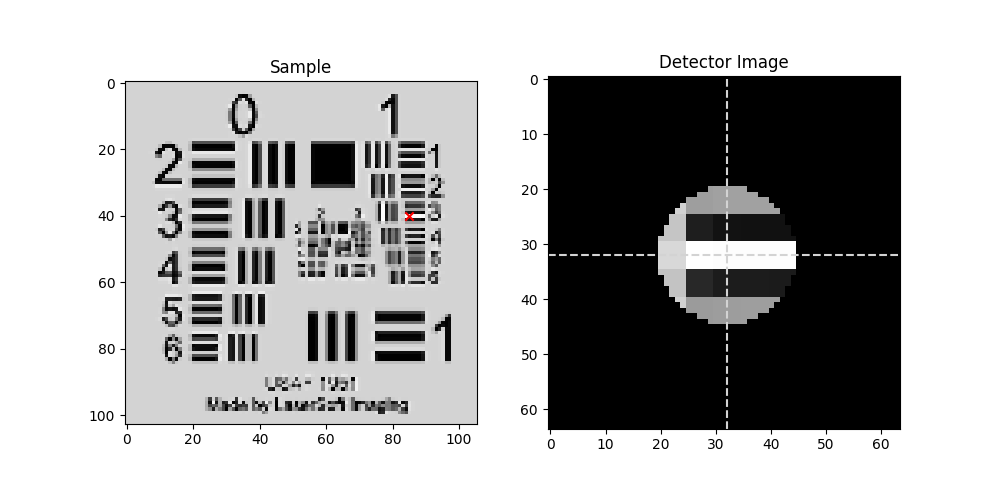

In [24]:
scan_idx_x, scan_idx_y = 85, 40
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(sample_image), 
             cmap='gray')
ax[0].scatter(scan_idx_x, scan_idx_y, c='r', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(detector_image.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(detector_image.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

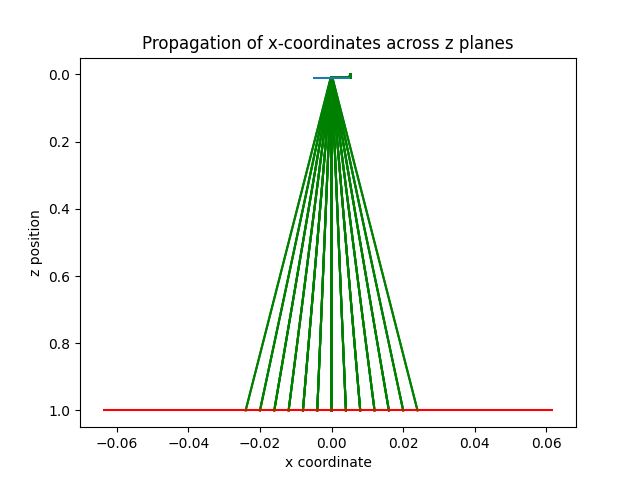

In [25]:
num_rays = xs.shape[-1]
plt.figure()
for ray in range(0, num_rays, 10):
    plt.plot(xs[:, ray], zs, color = 'g', alpha=1)

plt.hlines(zs[-1], det_coords_x[0], det_coords_x[-1], color='r', label='Detector')
plt.hlines(zs[1], sample_coords_x[0], sample_coords_x[-1])
plt.xlabel('x coordinate')
plt.ylabel('z position')
plt.title('Propagation of x-coordinates across z planes')
plt.gca().invert_yaxis()  # Invert the z-axis (display)
plt.show()


Text(0.5, 1.0, 'Ray at Sample and Detector')

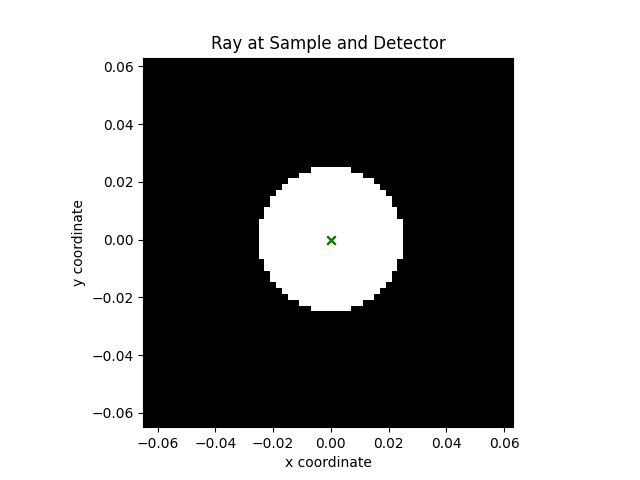

In [26]:
x_out_centre = np.array(x_out_centre)
y_out_centre = np.array(y_out_centre)
scan_x_in = np.array(scan_x_in)
scan_y_in = np.array(scan_y_in)

idx_x, idx_y = 102, 102
idx = np.ravel_multi_index((idx_y, idx_x), (scan_size[0], scan_size[1]))
det_image_selected = np.abs(fourdstem_array[idx_y, idx_x])

plt.figure()
plt.imshow(det_image_selected, cmap='gray', extent=[det_coords_x[0] - det_px_size/2, det_coords_x[-1] + det_px_size/2, det_coords_y[0] - det_px_size/2, det_coords_y[-1] + det_px_size/2], origin='lower')
plt.scatter(x_out_centre[idx], y_out_centre[idx], c='r', marker='x', alpha=1)
plt.scatter(x_out_centre_rm[idx], y_out_centre_rm[idx], c='g', marker='x', alpha=1)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Ray at Sample and Detector')

HALF BAKED ATTEMPT AT TRYING TO FIT OUTPUT POSITIONS OF IMAGES ON DETECTOR TO DESCAN ERROR COEFFICIENTS. NOT MY WHEELHOUSE THOUGH really, either way I don't think this can work based on some of the sympy mathematics above, as the coefficients are mixed together. 

In [27]:
import optax

def model(params, scan_x, scan_y):
    Exx, Eyy, Edxx, Edyy = params["Exx"], params["Eyy"], params["Edxx"], params["Edyy"]
    z_samp = params["z_samp"]
    x_pred = -scan_x + scan_x * (Exx + Edxx * z_samp)
    y_pred = -scan_y + scan_y * (Eyy + Edyy * z_samp)
    return x_pred, y_pred

# Define a function to compute the loss and its gradients
def loss(params, scan_x, scan_y, x_out, y_out):
    x_pred, y_pred = model(params, scan_x, scan_y)
    return jnp.sum((x_pred - x_out) ** 2 + (y_pred - y_out) ** 2)

scan_x_in = jnp.array(scan_x_in)
scan_y_in = jnp.array(scan_y_in)
x_out_centre = jnp.array(x_out_centre)
y_out_centre = jnp.array(y_out_centre)

descan_error = jnp.float32(descan_error)
# Example initial guess
params = {"Exx": 0., "Eyy": 0.,"Edxx": 0., "Edyy": 0.,"z_samp": 0.0}

# Set up an Adam optimizer
optimizer = optax.adam(1e-1)
opt_state = optimizer.init(params)

# One step of training
@jax.jit
def train_step(params, opt_state, scan_x, scan_y, x_out, y_out):
    loss_value, grads = jax.value_and_grad(loss, argnums=0)(params, scan_x, scan_y, x_out, y_out)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

losses = []


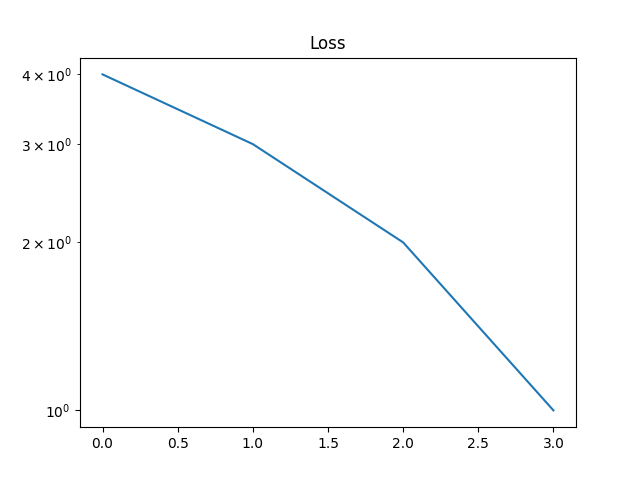

In [28]:
fig, ax = plt.subplots()
loss_plot = ax.plot(np.arange(1, 5)[::-1])[0]
ax.set_title("Loss")
ax.set_yscale("log")

In [29]:
import asyncio
# This is necessary to let the above plot initialize
await asyncio.sleep(0.5)

In [30]:
num_iterations = 4000
ax.set_xlim(0, num_iterations)
loss_plot.set_xdata(np.arange(num_iterations))
losses = np.full((num_iterations,), np.nan)

# Run a simple training loop
for step_idx in range(num_iterations):
    params, opt_state, current_loss = train_step(params, opt_state, scan_x_in, scan_y_in, x_out_centre, y_out_centre)
    losses[step_idx] = current_loss

    if (step_idx % 10) == 0:
        loss_plot.set_ydata(losses)
        ax.set_ylim(0.1 * np.nanmin(losses[:step_idx+1]), 1.1 * np.nanmax(losses[:step_idx+1]))
        fig.canvas.draw()

In [31]:
print(x_out_centre[0], y_out_centre[0])
print(scan_x_in[0], scan_y_in[0])

2.2737368e-11 5.820766e-11
-0.0053 -0.00515


In [32]:
real_params = {
    "Exx": descan_error[0],"Eyy": descan_error[1], "Edxx": descan_error[2],"Edyy": descan_error[3], "z_samp": camera_length
}
real_loss=loss(real_params, scan_x_in, scan_y_in, x_out_centre, y_out_centre)
print(real_loss)
test_loss=loss(params, scan_x_in, scan_y_in, x_out_centre, y_out_centre)
print(test_loss)
print(params)
print(real_params)

6.2319735e-13
6.1236227e-13
{'Edxx': Array(0., dtype=float32), 'Edyy': Array(0., dtype=float32), 'Exx': Array(0.9999998, dtype=float32), 'Eyy': Array(0.99999976, dtype=float32), 'z_samp': Array(0., dtype=float32)}
{'Exx': Array(1., dtype=float32), 'Eyy': Array(1., dtype=float32), 'Edxx': Array(0., dtype=float32), 'Edyy': Array(0., dtype=float32), 'z_samp': 1.0}


In [36]:
r, M, L, D = sp.symbols('r M L D', real=True)

print(sp.simplify((r * D) / (D + L)))
print(sp.simplify(r - (L * r) / (L + D)))

D*r/(D + L)
D*r/(D + L)
